In [1]:
import numpy as np 
import pandas as pd 
from pandas import datetime
from datetime import date
import holidays
import calendar
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from copy import deepcopy
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

from numpy import asarray
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

import random
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
# Generates batches for sequence data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

#tf.random.set_seed(0)
#random.seed(0)
#np.random.seed(0)
SEED = 0
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    #tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


/kaggle/input/kyiv-energo-dataset/kyiv_energo(2).csv


In [2]:
#чтение файла после анализа и добавления фич
df = pd.read_csv('/kaggle/input/kyiv-energo-dataset/kyiv_energo(2).csv')
df.drop(['Unnamed: 0','date'], 1, inplace=True)
#смена типа временной переменной
df['datetime'] = pd.to_datetime(df['datetime'])

In [3]:
#вывод предсказываемой переменной в конец датасета
df['loads']= df['actual_load']
df.drop('actual_load', 1, inplace=True)
df_copy = deepcopy(df)

#порядковые номера по датам для деления датасета
start = 20040 #indexes for the first test set 15.04.2017
stop = 20208 #22.04.2017
start_train = 11280 #15.04.2016

In [4]:
#функция для деления датасета на тренировочный и тестовый
def train_test_split(data, start_train, start, stop, features_to_drop):
    data.drop(features_to_drop, 1, inplace=True)
    train_X = data.iloc[start_train:start, :-1]
    test_X = data.iloc[start:stop,:-1] 
    train_y = data.iloc[start_train:start, -1]
    test_y = data.iloc[:start:stop, -1]
    return train_X, test_X, train_y, test_y
#первая разбивка датасета с удалением двух фич
train_X, test_X, train_y, test_y = train_test_split(df_copy, 0,
                start, stop, ['datetime', 'working_day'])

# **Почасовый прогноз 15.04.2017 - 22.01.2017**

In [5]:
#первая модель
reg = XGBRegressor(n_estimators=800)
reg.fit(train_X, train_y,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=800, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [6]:
df1 = deepcopy(df)
X_train, X_test, y_train, y_test = train_test_split(df1, start_train, 
                start, stop, ['working_day'])

def datetounix(df):
    # Calling an list of unixtime
    unixtime = []
    
    # Convert Date to seconds
    for date in df['datetime']:
        unixtime.append(time.mktime(date.timetuple()))
    
    # Replacing Date with unixtime list
    df['datetime'] = unixtime
    return(df)
#подготовка данных к использованию в нейросети
X_train = datetounix(X_train)
X = X_train.values
X_test = datetounix(X_test).values
y = y_train.values
sc = StandardScaler()
X = sc.fit_transform(X)
# нормализация предсказываемой переменной
y_train = (y - min(y))/(max(y) - min(y))
y_train
X_test = sc.fit_transform(X_test)

In [7]:
#нейросеть на данных за годовой период до начала предсказываемого срока
model = Sequential()
model.add(Dense(units = 20, kernel_initializer = 'uniform',input_dim =6, activation = 'relu'))
#model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
#model.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mae']) 
#Adam показал лучший результат, чем SGD Optimzer
model.fit(X, y_train, batch_size = 1, epochs = 20)
#количество эпох проверялось сначала с 30, потом 25, но эксперименты
#показали, что после 20 потери не уменьшаются

Epoch 1/20
8760/8760 [==============================] - 8s 905us/step - loss: 0.0176 - mae: 0.1023
Epoch 2/20
8760/8760 [==============================] - 8s 885us/step - loss: 0.0081 - mae: 0.0698
Epoch 3/20
8760/8760 [==============================] - 8s 897us/step - loss: 0.0076 - mae: 0.0672
Epoch 4/20
8760/8760 [==============================] - 8s 910us/step - loss: 0.0069 - mae: 0.0640
Epoch 5/20
8760/8760 [==============================] - 8s 917us/step - loss: 0.0069 - mae: 0.0635
Epoch 6/20
8760/8760 [==============================] - 8s 883us/step - loss: 0.0062 - mae: 0.0601
Epoch 7/20
8760/8760 [==============================] - 8s 895us/step - loss: 0.0064 - mae: 0.0610
Epoch 8/20
8760/8760 [==============================] - 8s 905us/step - loss: 0.0060 - mae: 0.0593
Epoch 9/20
8760/8760 [==============================] - 8s 905us/step - loss: 0.0061 - mae: 0.0591
Epoch 10/20
8760/8760 [==============================] - 8s 901us/step - loss: 0.0059 - mae: 0.0588
Epoch 11/

<AxesSubplot:xlabel='datetime'>

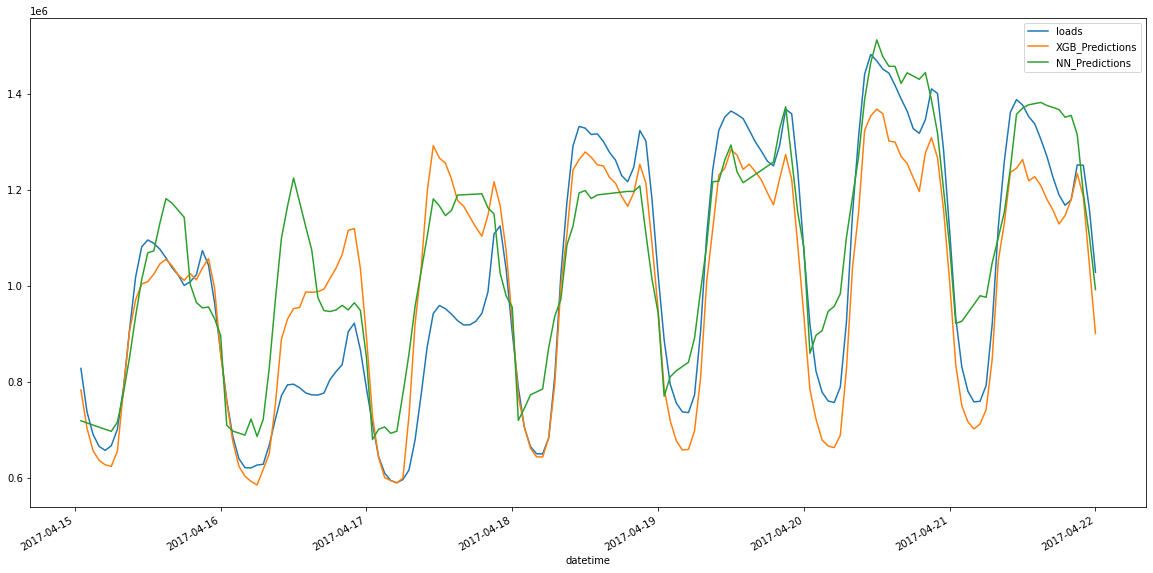

In [8]:
#предсказания нейросети
y_pred = model.predict(X_test)
y_pred =(y_pred * (max(y) - min(y))) + min(y)
predictions = [int(i) for i in y_pred]

#добавляю предсказания с обоих моделей в тест сет для построения графиков
test_set = df.iloc[start:stop, [1,7]]
test_set.set_index('datetime', inplace=True)
test_set["XGB_Predictions"] = reg.predict(test_X)
test_set["NN_Predictions"] = predictions

#график
test_set.plot(figsize=(20, 10))

In [9]:
#сравнение результатов MAPE
print("MAPE of XGBoost:", mean_absolute_percentage_error(test_set['loads'], 
                            test_set['XGB_Predictions'])*100, "%")

print("MAPE of NN:", mean_absolute_percentage_error(test_set['loads'], 
                            test_set['NN_Predictions'])*100, "%")

MAPE of XGBoost: 9.264179178047467 %
MAPE of NN: 12.109676275561258 %


**Где модель совершает ошибки?** В основном в прогнозах употребления электроэнергии в утренние часы и в ночное время. График нейросети не везде находит минимум, он немного выше реального. График Эксджибуста работает лучше, он точнее в минимальных значениях, хотя отстает в максимальных суточных значениях.  Причиной этому является сам месяц, для которого были сделаны предсказания - погода очень переменна в апреле, отопление иногда выключается совсем, а иногда включается, если холодает на улице. Последние дни в тренировочном датасете выпадали на немного более прохладные дни, где электроэнергии использовалось больше. Кроме того, выше мы видели, что расход электроэнергии в целом на выходные ниже, чем по будням. Но на данном графике мы видим, что в субботу расход достаточно большой. Если посмотреть в данные за 15 и 16 апреля 2017 года и на график температур ниже, то разница в дневной температуре между ними не критична, 16 апреля было лишь немного теплее, хотя расход электроэнергии сильно уменьшился. К сожалению, у нас нет других погодных данных, например, был ли в субботу дождь или ветер, что приводило бы к большему расходу электричества и к тому, что люди чаще сидели бы по домам, а в воскресенье, например, выбрались, на прогулку.

В понедельник и вторник заметно похолодало, что и привело к росту расходов электроэнергии. Этот внезапный поворот модель поймала очень хорошо. 

In [10]:
#температура воздуха за предсказываемый период
test_graph = df.iloc[start:stop,:] 
test_graph.reset_index(inplace=True)
px.line(test_graph, x = 'datetime', y = ['temperature'])

#  **Посуточный прогноз 15.04.2017 - 15.05.2017**

In [11]:
#индексы для деления датасета на тренировочный и тестовый
start_train1 = 0 #11280 #15.04.2016
start1 = 20040 #15.04.2017
stop1 = 20760 #15.05.2017

#деление датасета
df_copy1 = deepcopy(df)
train_X1, test_X1, train_y1, test_y1 = train_test_split(df_copy1, 0,
                start1, stop1, ['datetime', 'working_day'])
#модель
reg = XGBRegressor(n_estimators=800)
reg.fit(train_X, train_y,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=800, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
#подготовка данных к использованию в нейросети
df_c1 = deepcopy(df)

X_train1, X_test1, y_train1, y_test1 = train_test_split(df_c1, start_train1, 
                start1, stop1, ['working_day'])

X_train1 = datetounix(X_train1)
X1 = X_train1.values
X_test1 = datetounix(X_test1).values
y1 = y_train1.values
sc = StandardScaler()
X1 = sc.fit_transform(X1)
#нормализация предсказываемой переменной
y_train1 = (y1 - min(y1))/(max(y1) - min(y1))
X_test1 = sc.fit_transform(X_test1)

In [13]:
#нейросеть
model1 = Sequential()
model1.add(Dense(units = 10, kernel_initializer = 'uniform',input_dim =6, activation = 'relu'))
model1.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
#model1.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'relu'))
model1.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
model1.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mae']) 
#Adam показал лучший результат, чем SGD Optimzer
model1.fit(X1, y_train1, batch_size = 1, epochs = 20)

Epoch 1/20
20040/20040 [==============================] - 20s 965us/step - loss: 0.0142 - mae: 0.0920
Epoch 2/20
20040/20040 [==============================] - 20s 980us/step - loss: 0.0079 - mae: 0.0695
Epoch 3/20
20040/20040 [==============================] - 20s 979us/step - loss: 0.0074 - mae: 0.0668
Epoch 4/20
20040/20040 [==============================] - 20s 1ms/step - loss: 0.0068 - mae: 0.0634
Epoch 5/20
20040/20040 [==============================] - 20s 991us/step - loss: 0.0071 - mae: 0.0644
Epoch 6/20
20040/20040 [==============================] - 20s 981us/step - loss: 0.0054 - mae: 0.0558
Epoch 7/20
20040/20040 [==============================] - 20s 991us/step - loss: 0.0035 - mae: 0.0448
Epoch 8/20
20040/20040 [==============================] - 20s 974us/step - loss: 0.0033 - mae: 0.0425
Epoch 9/20
20040/20040 [==============================] - 19s 962us/step - loss: 0.0030 - mae: 0.0409
Epoch 10/20
20040/20040 [==============================] - 20s 1ms/step - loss: 0.00

<AxesSubplot:xlabel='datetime'>

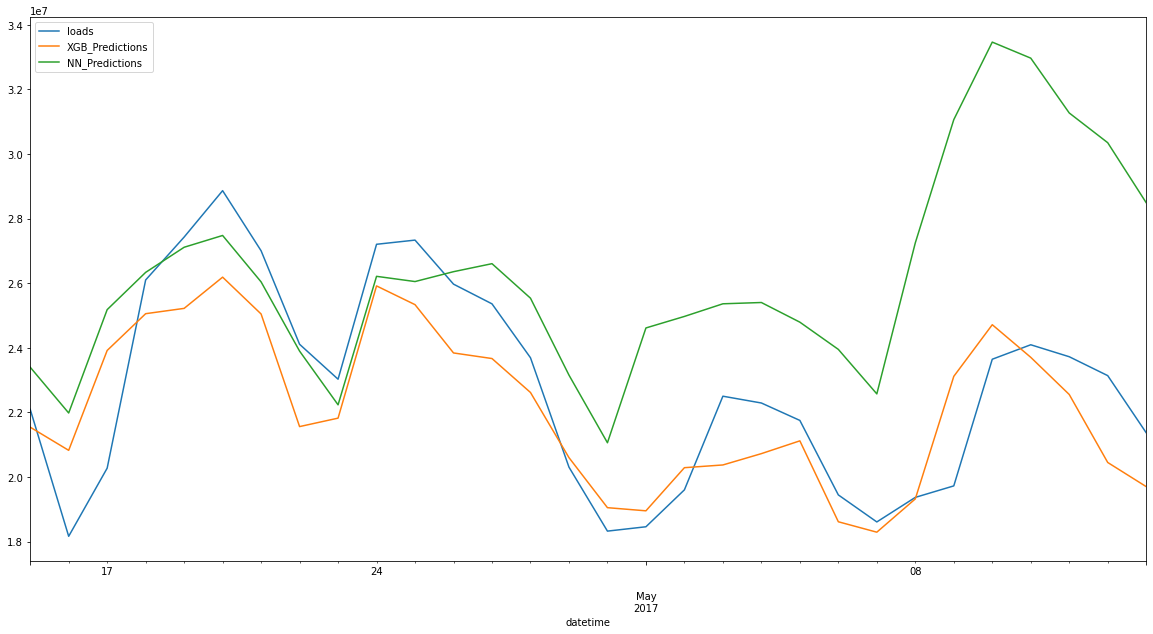

In [14]:
#предсказания нейросети
y_pred1 = model.predict(X_test1)
y_pred1 =(y_pred1 * (max(y1) - min(y1))) + min(y1)
predictions1 = [int(i) for i in y_pred1]

#создание датасета с актуальными данными и предсказаниями для графика
test_set1 = df.iloc[start1:stop1, [1,7]]
test_set1.set_index('datetime', inplace=True)
test_set1.shape
#почасовый прогноз
test_set1["XGB_Predictions"] = reg.predict(test_X1)
test_set1["NN_Predictions"] = predictions1
#рисемпл всех трех колонок посуточно
df_daily = test_set1.resample('D').sum()

#график
df_daily.plot(figsize=(20, 10))

In [15]:
#сравнение результатов МАРЕ
print("MAPE of XGBoost:", mean_absolute_percentage_error(df_daily['loads'], 
                            df_daily['XGB_Predictions'])*100, "%")
print("MAPE of NN:", mean_absolute_percentage_error(df_daily['loads'], 
                            df_daily['NN_Predictions'])*100, "%")

MAPE of XGBoost: 6.528897056320905 %
MAPE of NN: 17.868424577524337 %


Здесь мы видим, что прогноз стал лучше - нейросеть сначала очень близка к реальным данным, а потом начинает совершать ошибки, в то время как XGBoost демонстрирует стабильность в прогнозах. Глядя на показатели МАРЕ, мы можем заключить улучшение предсказаний по сравнению с первым вариантом. Почему так произошло? Потому что предсказывали изначально почасово, а потом произвели рисемплинг данных посуточно, прибавив все почасовые показатели в суточные. Если где-то были большие несопадения в посуточных величинах, они компенсировали сами себя в итоговых суммарных. 

# **Помесячный прогноз с апреля по сентябрь (не включая) 2017**

In [16]:
#индексы для деления датасета в третьем варианте моделей
start_train2 = 0
start2 = 19704
stop2=23376

#деление датасета
df_monthly = deepcopy(df)
train_X_m, test_X_m, train_y_m, test_y1_m = train_test_split(df_monthly, 0,
                start2, stop2, ['datetime', 'working_day'])
#модель
reg = XGBRegressor(n_estimators=800)
reg.fit(train_X_m, train_y_m,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=800, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
#подготовка данных к использованию нейросети
df_m = deepcopy(df)

X_trainm, X_testm, y_trainm, y_testm = train_test_split(df_m, 0, 
                start2, stop2, ['working_day'])

X_trainm = datetounix(X_trainm)
Xm = X_trainm.values
X_testm = datetounix(X_testm).values
ym = y_trainm.values
sc = StandardScaler()
Xm = sc.fit_transform(Xm)
# Normalizing the target variables
y_trainm = (ym - min(ym))/(max(ym) - min(ym))
X_testm = sc.fit_transform(X_testm)

In [18]:
#нейросеть
model2 = Sequential()
model2.add(Dense(units = 10, kernel_initializer = 'uniform',input_dim =6, activation = 'relu'))
model2.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
#model2.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'relu'))
model2.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
model2.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mae']) 
#Adam показал лучший результат, чем SGD Optimzer
model2.fit(Xm, y_trainm, batch_size = 1, epochs = 15)

Epoch 1/15
19704/19704 [==============================] - 20s 996us/step - loss: 0.0150 - mae: 0.0951
Epoch 2/15
19704/19704 [==============================] - 20s 994us/step - loss: 0.0079 - mae: 0.0693
Epoch 3/15
19704/19704 [==============================] - 19s 972us/step - loss: 0.0074 - mae: 0.0666
Epoch 4/15
19704/19704 [==============================] - 19s 958us/step - loss: 0.0068 - mae: 0.0636
Epoch 5/15
19704/19704 [==============================] - 19s 957us/step - loss: 0.0044 - mae: 0.0506
Epoch 6/15
19704/19704 [==============================] - 19s 956us/step - loss: 0.0040 - mae: 0.0476
Epoch 7/15
19704/19704 [==============================] - 19s 961us/step - loss: 0.0038 - mae: 0.0464
Epoch 8/15
19704/19704 [==============================] - 19s 967us/step - loss: 0.0037 - mae: 0.0460
Epoch 9/15
19704/19704 [==============================] - 19s 945us/step - loss: 0.0035 - mae: 0.0449
Epoch 10/15
19704/19704 [==============================] - 19s 985us/step - loss: 

<AxesSubplot:xlabel='datetime'>

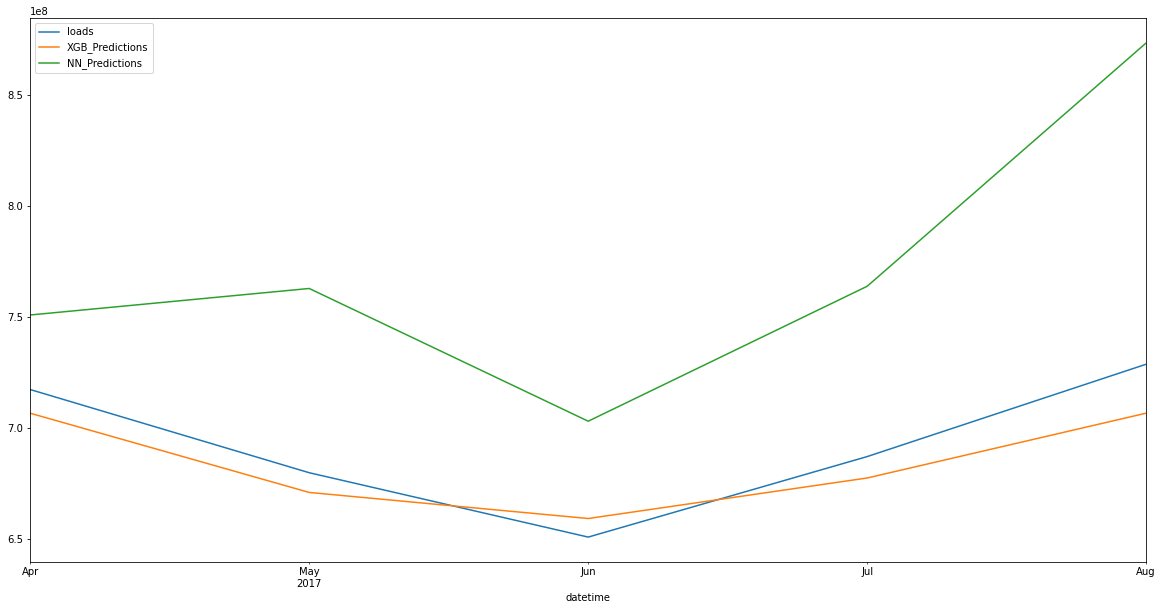

In [19]:
#предсказания нейросети
y_pred2 = model.predict(X_testm)
y_pred2 =(y_pred2 * (max(ym) - min(ym))) + min(ym)
predictions2 = [int(i) for i in y_pred2]

#создание датасета с актуальными результатами и предсказаниями для построения графиков
test_set2 = df.iloc[start2:stop2, [1,7]]
test_set2.set_index('datetime', inplace=True)
test_set2.shape
#почасовые предсказания
test_set2["XGB_Predictions"] = reg.predict(test_X_m)
test_set2["NN_Predictions"] = predictions2
#рисемпл всех трех колонок помесячно
test_month = test_set2.resample('M').sum()

#график
test_month.plot(figsize=(20, 10))

In [20]:
#сравнение результатов МАРЕ
print("MAPE of XGBoost:", mean_absolute_percentage_error(test_month['loads'], 
                            test_month['XGB_Predictions'])*100, "%")
print("MAPE of NN:", mean_absolute_percentage_error(test_month['loads'], 
                            test_month['NN_Predictions'])*100, "%")

MAPE of XGBoost: 1.7025635021305323 %
MAPE of NN: 11.19179228419384 %


Во-первых, разница между прогнозами XGBoost и нейросети катастрофическая - МАРЕ отличается в 6 раз. На фоне остальных прогнозов МАРЕ нейросеть демонстрирует улучшение по этому показателю, но не по графическому. По сравнению с результатами XGBoost (1,7%), эта оценка тоже очень низкая. Во-вторых, улучшение результатов прогнозов происходит по причине того, что мы аккумулируем результаты почасового прогноза в помесячные и разница в суммах потребления электроэнергии становится менее заметной, нежели она была бы для почасовых предсказаний. Почему я использовала именно такой вариант? Ведь можно было бы сделать рисемпл данных до использования их в модели. Ответ простой: таким образом у меня было больше данных для построения модели, и результат оказался точнее, чем если бы использовала намного меньше строк с уже переформатированными данными.  

В целом можно сказать, что для решения этой задачи я бы воспользовалась в первую очередь XGBoost и попробовала бы ещё Random Forest Regressor. Также были испробованы LSTM Facebook's Neural Prophet но первые требуют большой вычислительной мощности техники, а второй в силу того, что не принимает дополнительные фичи, а строит предсказания только на основании предсказываемой переменной, оказался не так эффективен как XGBoost, хотя временами немного лучше, чем классические нейросети.

**Что не сработало?**
Например, такие фичи как "рабочие дни", которая была создана на основе учета праздников и выходных; "месяц", "четверть". Эти календарные колонки не улучшили результат, а даже ухудшили его, поэтому были исключены.

**Что может улучшить результат?**
Думаю, что нужно учесть больше данных о погоде, например, влажность и ветер. Ведь в сырую погоду летом жара кажется ещё более невыносимой, что приводит к расходам электроэнергии на кондиционер. А зимой влажность и ветер требуют дополнительного отопления жилищ, поскольку тепло уходит быстрее.